In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
!pip install mnist

  Using cached mnist-0.2.2-py2.py3-none-any.whl (3.5 kB)


In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels=mnist.train_labels()
train_images.shape,train_labels.shape

((60000, 28, 28), (60000,))

In [6]:
test_images=mnist.test_images()
test_labels=mnist.test_labels()
test_images.shape,test_labels.shape

((10000, 28, 28), (10000,))

5


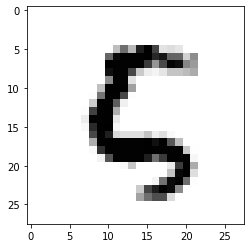

In [7]:
image_index=2000
print(train_labels[image_index])
plt.imshow(train_images[image_index],cmap='Greys')

In [8]:
train_filter = np.where((train_labels == 3) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train,y_train = train_images[train_filter],train_labels[train_filter]
X_test,y_test = test_images[test_filter],test_labels[test_filter]

In [9]:
X_train=X_train/255
X_test=X_test/255

In [10]:
y_train = 1*(y_train == 3)
y_test = 1*(y_test == 3)
y3 = y_test.sum()
y8 = len(y_test)-y3
y3,y8

(1010, 974)

In [11]:
X_train.shape,X_test.shape

((11982, 28, 28), (1984, 28, 28))

In [12]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((11982, 784), (1984, 784), (11982, 1), (1984, 1))

In [13]:
from kudzu.data import Data,Dataloader,Sampler

data_train =Data(X_train,y_train)
data_test =X_test

In [14]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 200
config.bs = 50

In [15]:
sampler = Sampler(data_train, config.bs, shuffle=True)

In [16]:
dl_train = Dataloader(data_train,sampler)

In [17]:
from kudzu.callbacks import Callback,take_mean

In [18]:
from kudzu.layer import Layer,Affine,Activation,Relu,Sigmoid
layers = [Affine("first",784,100),Relu("relu1"),Affine("second",100,100),Relu("relu2"),Affine("third",100,2),Affine("last",2,1),Sigmoid("sigmoid")]

xavier
xavier
xavier
xavier


In [19]:
from kudzu.callbacks import Callback,AccCallback

In [20]:
class ClfCallback(AccCallback):
    def __init__(self,learner,bs):
        super().__init__(learner,bs)
        self.accuracies = []
        self.test_accuracies = []
    def epoch_end(self,train_predicted,p_train,test_predicted,p_test):
        super().epoch_end()
        self.accuracies.append(p_train)
        self.test_accuracies.append(p_test)
        self.train_predictions=np.array(train_predicted)
        self.test_predictions=np.array(test_predicted)

In [21]:
from kudzu.loss import BCE
from kudzu.model import Model
from kudzu.optim import GD 
loss = BCE()
model = Model(layers)
opt = GD(config.lr)

In [22]:
from kudzu.train import Learner
learner = Learner(loss, model, opt, config.num_epochs)
cfc = ClfCallback(learner, config.bs)
learner.set_callbacks([cfc])

# Training and testing
And accuracies per epoch

In [23]:
learner.train_loop(dl_train,X_train,y_train,data_test,y_test)

 epoch_accuracy:0.8347521281922884 , epoch_test_accuracy:0.8457661290322581
Epoch 0 Loss 0.6208000886940501
 epoch_accuracy:0.8913370055082624 , epoch_test_accuracy:0.9042338709677419
 epoch_accuracy:0.9092805875479887 , epoch_test_accuracy:0.9178427419354839
 epoch_accuracy:0.9212151560674345 , epoch_test_accuracy:0.9279233870967742
 epoch_accuracy:0.9288098814889 , epoch_test_accuracy:0.9369959677419355
 epoch_accuracy:0.9349858120514104 , epoch_test_accuracy:0.9475806451612904
 epoch_accuracy:0.9386579869804708 , epoch_test_accuracy:0.9516129032258065
 epoch_accuracy:0.943248205641796 , epoch_test_accuracy:0.9551411290322581
 epoch_accuracy:0.9463361709230512 , epoch_test_accuracy:0.9601814516129032
 epoch_accuracy:0.9498414288098815 , epoch_test_accuracy:0.9601814516129032
 epoch_accuracy:0.9509263895843766 , epoch_test_accuracy:0.9616935483870968
Epoch 10 Loss 0.15325518347586561
 epoch_accuracy:0.9531797696544817 , epoch_test_accuracy:0.9632056451612904
 epoch_accuracy:0.95459856

0.014458336021475436

# Plots

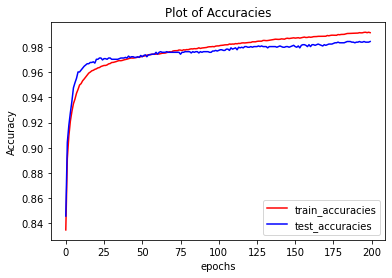

In [24]:
plt.plot(cfc.accuracies,'r',label='train_accuracies')
plt.plot(cfc.test_accuracies,'b',label='test_accuracies')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracies')
plt.legend()


Text(0.5, 1.0, 'Plot of losses')

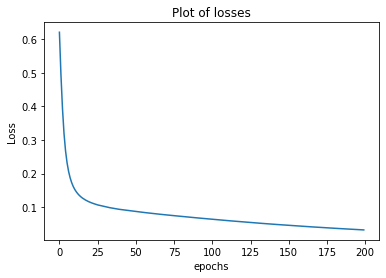

In [25]:
plt.plot(cfc.losses)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Plot of losses')

# Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix
train_cm=confusion_matrix(y_train,cfc.train_predictions)
test_cm=confusion_matrix(y_test,cfc.test_predictions)
print(f'false negatives in traning set :{train_cm[1,0]}')
print(f'false positives in traning set :{train_cm[0,1]}')
print(f'false negatives in test set :{test_cm[1,0]}')
print(f'false positives in test set :{test_cm[0,1]}')


false negatives in traning set :60
false positives in traning set :43
false negatives in test set :12
false positives in test set :19


In [27]:
new_model = Model(layers[:-2])
inputs = new_model(X_train)
inputs.shape

(11982, 2)

In [28]:
w1 = cfc.get_weights('last',0)[-1]
w2 = cfc.get_weights('last',1)[-2]
b = cfc.get_biases('last')[-1]

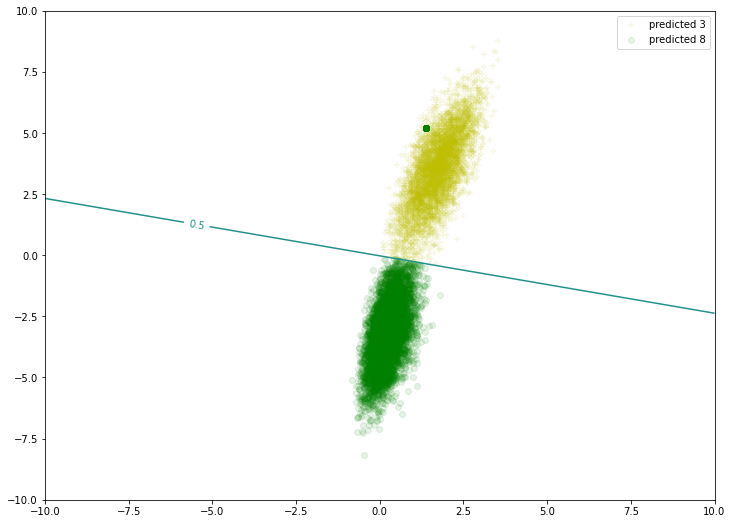

In [29]:
#fig = plt.figure(figsize = (10,6))
#ax=fig.gca()
fig=plt.figure(figsize=(12,9))
ax=fig.gca()
X1,X2 = np.meshgrid(np.linspace(-10,10,200),np.linspace(-10,10,200))
p = lambda m,n: w1*m + w2*n +b
prob_line = layers[-1](p(X1,X2))
contours = plt.contour(X1,X2,prob_line,1)
plt.clabel(contours,inline=True)
yp3=np.argwhere(cfc.train_predictions==1)
yp8=np.argwhere(cfc.train_predictions==0)
plt.scatter(inputs[:,0][yp3],inputs[:,1][yp3],marker='+',color='y',alpha=0.1,label='predicted 3')
plt.scatter(inputs[:,0][yp8],inputs[:,1][yp8],marker='o',color='g',alpha=0.1,label='predicted 8')
plt.legend()

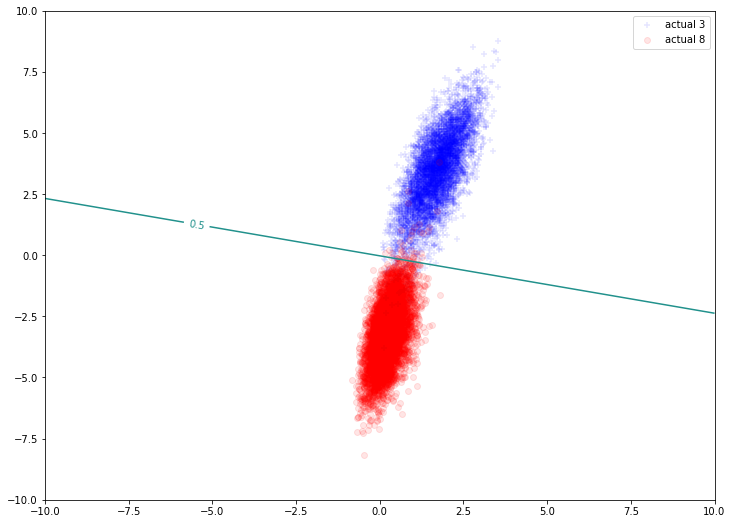

In [30]:
fig=plt.figure(figsize=(12,9))
ax=fig.gca()
X1,X2 = np.meshgrid(np.linspace(-10,10,200),np.linspace(-10,10,200))
p = lambda m,n: w1*m + w2*n +b
prob_line = layers[-1](p(X1,X2))
contours = plt.contour(X1,X2,prob_line,1)
plt.clabel(contours,inline=True)
y_train2=y_train.ravel()
y3=np.argwhere(y_train2==1)
y8=np.argwhere(y_train2==0)
plt.scatter(inputs[:,0][y3],inputs[:,1][y3],marker='+',color='b',alpha=0.1,label='actual 3')
plt.scatter(inputs[:,0][y8],inputs[:,1][y8],marker='o',color='r',alpha=0.1,label='actual 8' )
plt.legend()

# logistic Regression

In [31]:
layers2=[Affine('first',784,1),Sigmoid('sig')]
loss2 = BCE()
model2 = Model(layers2)
opt2 = GD(config.lr)

xavier


In [32]:
learner2 = Learner(loss2, model2, opt2, config.num_epochs)
cfc2 = ClfCallback(learner2, config.bs)
learner2.set_callbacks([cfc2])


In [33]:
learner2.train_loop(dl_train,X_train,y_train,data_test,y_test)


 epoch_accuracy:0.7812552161575697 , epoch_test_accuracy:0.7888104838709677
Epoch 0 Loss 0.6715053206301573
 epoch_accuracy:0.8809881488900017 , epoch_test_accuracy:0.8946572580645161
 epoch_accuracy:0.9021866132532131 , epoch_test_accuracy:0.9163306451612904
 epoch_accuracy:0.9091136705057586 , epoch_test_accuracy:0.922883064516129
 epoch_accuracy:0.913119679519279 , epoch_test_accuracy:0.9284274193548387
 epoch_accuracy:0.9154565181104991 , epoch_test_accuracy:0.9339717741935484
 epoch_accuracy:0.9190452345184443 , epoch_test_accuracy:0.9359879032258065
 epoch_accuracy:0.9210482390252045 , epoch_test_accuracy:0.9380040322580645
 epoch_accuracy:0.9232181605741946 , epoch_test_accuracy:0.9380040322580645
 epoch_accuracy:0.9253046236020698 , epoch_test_accuracy:0.9410282258064516
 epoch_accuracy:0.9266399599399099 , epoch_test_accuracy:0.9415322580645161
Epoch 10 Loss 0.26637226940033865
 epoch_accuracy:0.92830913036221 , epoch_test_accuracy:0.9420362903225806
 epoch_accuracy:0.92931063

0.09158574083300774

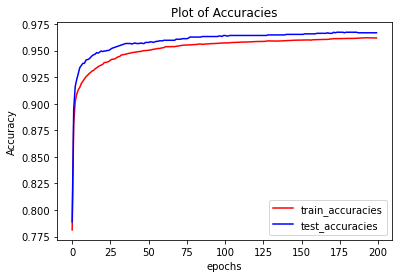

In [34]:
plt.plot(cfc2.accuracies,'r',label='train_accuracies')
plt.plot(cfc2.test_accuracies,'b',label='test_accuracies')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracies')
plt.legend()


Text(0.5, 1.0, 'Plot of losses')

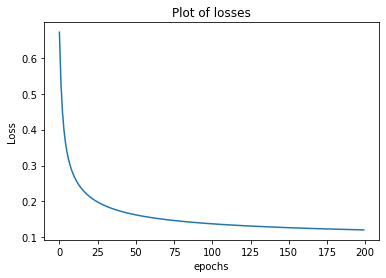

In [35]:
plt.plot(cfc2.losses)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Plot of losses')

In [36]:
from sklearn.metrics import confusion_matrix
train_cm=confusion_matrix(y_train,cfc2.train_predictions)
test_cm=confusion_matrix(y_test,cfc2.test_predictions)
print(f'false negatives in traning set :{train_cm[1,0]}')
print(f'false positives in traning set :{train_cm[0,1]}')
print(f'false negatives in test set :{test_cm[1,0]}')
print(f'false positives in test set :{test_cm[0,1]}')

false negatives in traning set :264
false positives in traning set :193
false negatives in test set :33
false positives in test set :33


Conparision between neural networks and logistic Regression:
False values are high when we perform Logistic Regression